In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import plenoptic as po
import scipy.io as sio
import os
import os.path as op
import glob
import math
import pyrtools as pt
from tqdm import tqdm
from PIL import Image
%load_ext autoreload
%autoreload 

# download some texture files if you don't already have them:
import sys
sys.path.append('../tests/')
from test_metric import osf_download
results_dir = osf_download('portilla_simoncelli_images.tar.gz')
DATA_PATH = '../data/portilla_simoncelli_images/'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72

# set seed for reproducibility
po.tools.set_seed(1)

In [2]:
# These variables control how long metamer synthesis runs for. The values present here will result in completed synthesis,
# but you may want to decrease these numbers if you're on a machine with limited resources.
short_synth_max_iter = 1000
long_synth_max_iter = 3000
longest_synth_max_iter = 4000

# Portilla-Simoncelli Texture Metamer tutorial

In this tutorial we will aim to replicate [Portilla & Simoncelli (1999)](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf). The tutorial is broken into the following parts:


1. Introduce the concept of a Visual Texture.
2. How to synthesize metamers for the Portilla & Simoncelli texture model. 
3. Demonstrate the importance of different classes of statistics.
4. Example syntheses from different classes of textures (e.g., artificial, Julesz, pseudoperiodic, etc.)
5. Extrapolation and Mixtures: Applying texture synthesis to more complex texture problems.
6. Some model limitations.
7. List of notable differences between the MATLAB and python implementations of the Portilla Simoncelli texture model and texture synthesis.

Note that this notebook takes a long time to run (roughly an hour with a GPU, several hours without), because of all the metamers that are synthesized.

## 1 What is a visual texture?

The simplest definition is a repeating visual pattern. Textures encompass a wide variety of images, including natural patterns such as bark or fur, man-made ones such as brick, and computer-generated ones such as the Julesz patterns ([Julesz 1978](https://link.springer.com/article/10.1007/BF00336998), [Yellot 1993](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-10-5-777)). Below we load some examples.  

The Portilla-Simoncelli model was developed to measure the statistical properties of visual textures.  Metamer synthesis was used (and can be used) in conjunction with the Portilla-Simoncelli texture model to demonstrate the necessity of different properties of the visual texture.  We will use some of these example textures to demonstrate aspects of the Portilla Simoncelli model.

/home/billbrod/Documents/plenoptic/plenoptic/tools/data.py:133: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.tensor(images, dtype=torch.float32)


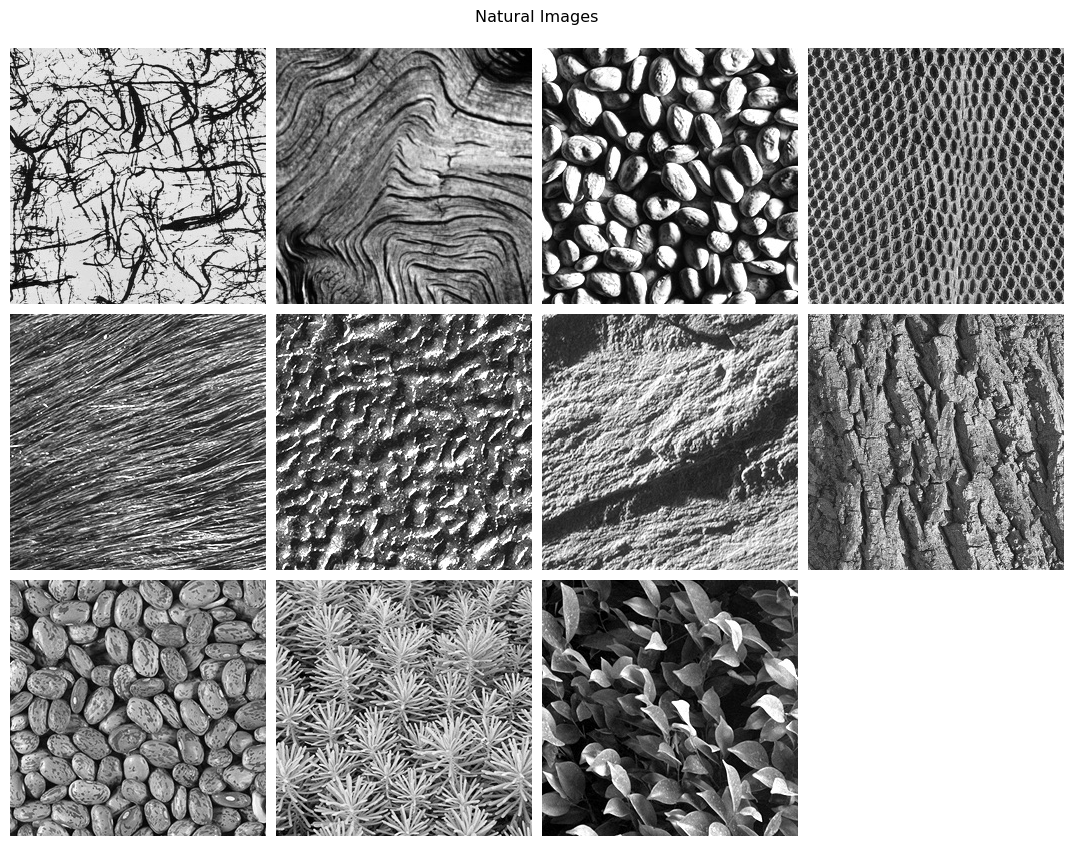

In [3]:
# Load and display a set of visual textures

def display_images(im_files, title=None):
    images = po.tools.load_images(im_files)
    fig = po.imshow(images, col_wrap=4, title=None)
    if title is not None:
        fig.suptitle(title, y=1.05)

directory = DATA_PATH
natural = ['3a','6a','8a','14b','15c','15d','15e','15f','16c','16b','16a']
manmade = ['4a','4b','14a','16e','14e','14c','5a']
artificial = ['5b','13a','13b','13c','13d']

im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in natural]
display_images(im_files, "Natural Images")

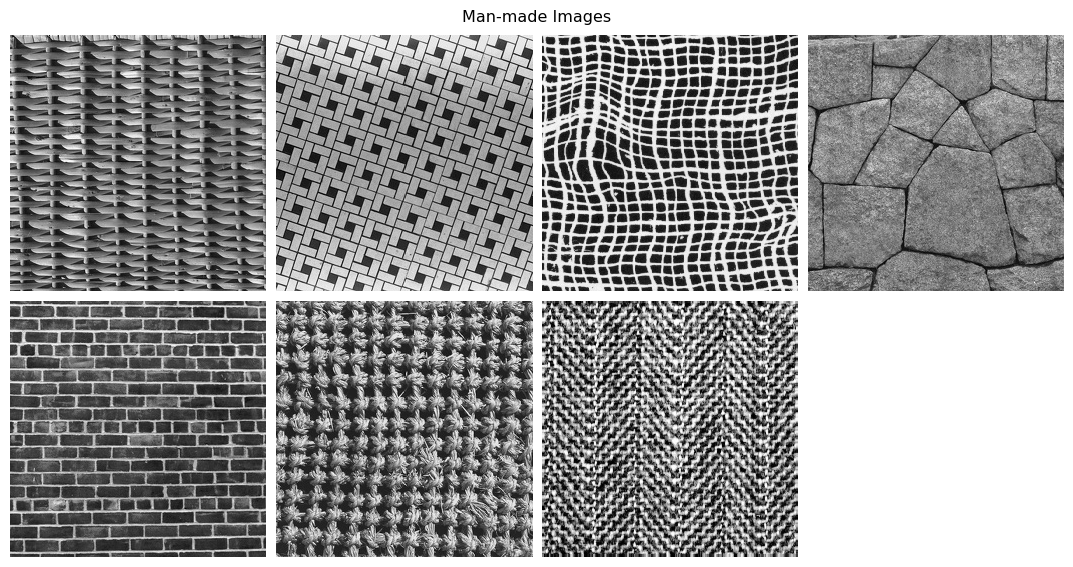

In [4]:
im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in manmade]
display_images(im_files, 'Man-made Images')

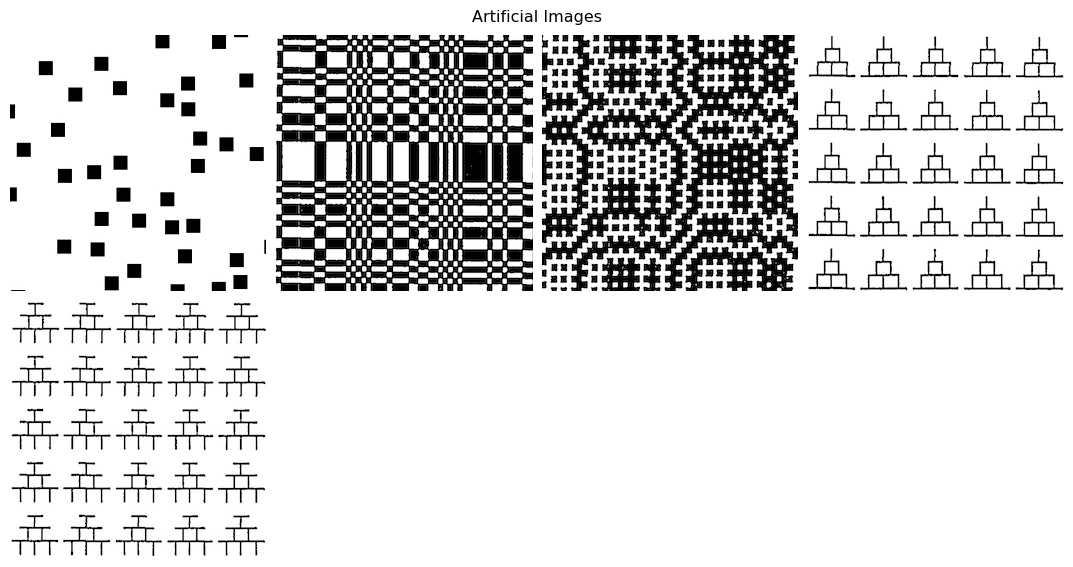

In [5]:
im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in artificial]
display_images(im_files, 'Artificial Images')


## 2. How to generate Portilla-Simoncelli Metamers

### 2.1 A quick reminder of what metamers are and why we are calculating them.

The primary reason that the original Portilla-Simoncelli paper developed the metamer procedure was to assess whether a model sees like human.  Basically we generate samples of images that "look the same" to the model and then examine them or run experiments to see if they also "look the same" to a human.

### 2.2 How do we use the plenoptic package to generate Portilla-Simoncelli Texture Metamers?
For a model, two images are metamers if the model response to both images is equal (within some tolerance).  Generating a metamer starts with a target image:

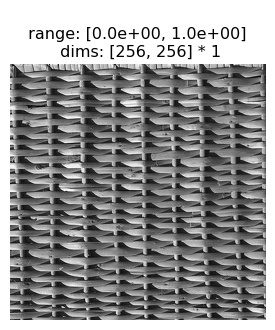

In [6]:
img = po.tools.load_images(DATA_PATH + 'fig4a.jpg')
po.imshow(img);

Below we have an instance of the PortillaSimoncelli model with default parameters.  
The default parameters of PortillaSimoncelli are:
- `n_scales=4`, The number of scales in the steerable pyramid underlying the model.
- `n_orientations=4`, The number of orientations in the steerable pyramid.
- `spatial_corr_width=9`, The size of the window used to calculate the correlations across steerable pyramid bands.

Running the model on an image will return a vector of numbers summarizing the "texturiness" of that image, which we refer to as the model's representation. These statistics are measurements of different properties that the authors considered relevant to a texture's appearance (where a texture is defined above), and capture some of the repeating properties of these types of images. Section 3 of this notebook explores those statistics and how they relate to texture properties.

When the model representation of two images match, the model considers the two images identical and we say that those two images are model metamers. Synthesizing a novel image that matches the representation of some arbitrary input is the goal of the `Metamer` class.

In [7]:
n=img.shape[-1]
model = po.simul.PortillaSimoncelli([n,n])
stats = model(img)
print(stats)

tensor([[[0.4350, 0.0407, 0.1622,  ..., 0.0000, 0.0000, 0.0023]]])


To use `Metamer`, simply initialize it with the target image and the model, then call `.synthesize()`. By setting `store_progress=True`, we update a variety of attributes (all of which start with `saved_`) on each iteration so we can later examine, for example, the synthesized image over time.  Let's quickly run it for just 10 iterations to see how it works.

In [8]:
met = po.synth.Metamer(img, model)
met.synthesize(store_progress=True, max_iter=10)

/home/billbrod/Documents/plenoptic/plenoptic/tools/validate.py:178: UserWarning: model is in training mode, you probably want to call eval() to switch to evaluation mode
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

We can then call the `plot_synthesis_status` method to see how things are doing. The image on the left shows the metamer at this moment in synthesis, while the center plot shows the loss over time, with the red dot pointing out the current loss, and the rightmost plot shows the representation error. For the texture model, we plot the difference in representations split up across the different category of statistics (which we'll describe in more detail later).

/home/billbrod/Documents/plenoptic/plenoptic/tools/display.py:960: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


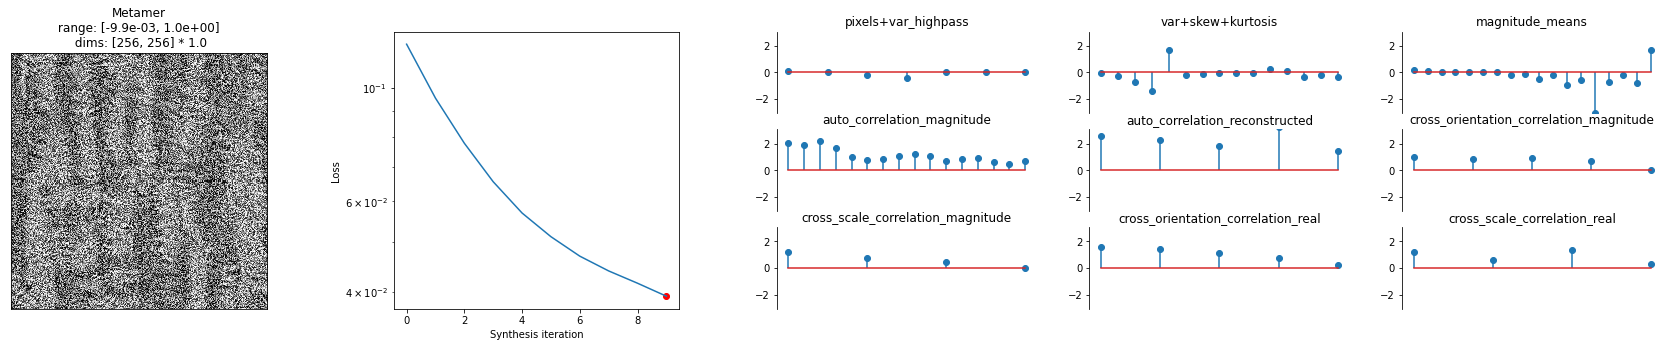

In [9]:
# representation_error plot has three subplots, so we increase its relative width
po.synth.metamer.plot_synthesis_status(met, width_ratios={'plot_representation_error': 3.1});

### 2.3 Portilla-Simoncelli Texture Model Metamers

This section will show a successful texture synthesis for this wicker basket texture:

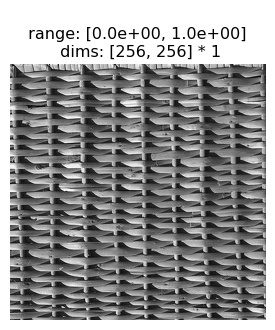

In [10]:
po.imshow(img);

In the next block we will actually generate a metamer using the PortillaSimoncelli model, setting the following parameters for synthesis: `max_iter`, `store_progress`,`coarse_to_fine`, and `coarse_to_fine_kwargs`.  
- `max_iter=1000` puts an upper bound (of 1000) on the number of iterations that the optimization will run.
- `store_progress=True` tells the metamer class to store the progress of the metamer synthesis process
- `coarse_to_fine='together'` activates the coarse_to_fine functionality.  With this mode turned on the metamer synthesis optimizes the image for the statistics associated with the low spatial frequency bands first, adding subsequent bands after `ctf_iters_to_check` iterations.

It takes about 50s to run 100 iterations on my laptop.  And it takes hundreds of iterations to get convergence. So you'll have to wait a few minutes to generate the texture metamer. 

Note: we initialize synthesis with `im_init`, an initial uniform noise image with range `mean(target_signal)+[-.05,.05]`.  Initial images with uniform random noise covering the full pixel domain `[0,1]` (which is the default choice for Metamer) don't result in the very best metamers.  With the full range initial image, the optimization seems to get stuck.

In [11]:
# send image and PS model to GPU, if available. then im_init and Metamer will also use GPU
img = img.to(DEVICE)
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
im_init = (torch.rand_like(img)-.5) * .1 + img.mean();
met = po.synth.MetamerCTF(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init,
                          coarse_to_fine='together')

o=met.synthesize(
    max_iter=short_synth_max_iter,
    store_progress=True,
    # setting change_scale_criterion=None means that we change scales every ctf_iters_to_check,
    # see the metamer notebook for details.
    change_scale_criterion=None, 
    ctf_iters_to_check=7
    )

/home/billbrod/Documents/plenoptic/plenoptic/tools/validate.py:211: UserWarning: Validating whether model can work with coarse-to-fine synthesis -- this can take a while!
  warnings.warn("Validating whether model can work with coarse-to-fine synthesis -- this can take a while!")


  0%|          | 0/10 [00:00<?, ?it/s]

Now we can visualize the output of the synthesis optimization. First we compare the *Target image* and the *Synthesized image* side-by-side. We can see that they appear perceptually similar --- that is, for this texture image, matching the Portilla-Simoncelli texture stats gives you an image that the human visual system *also* considers similar.

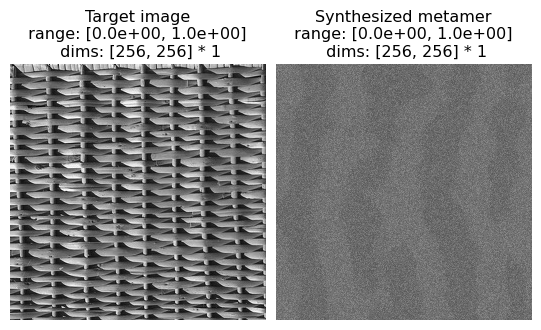

In [12]:
po.imshow([met.image, met.metamer], title=['Target image', 'Synthesized metamer'], vrange='auto1');

And to further visualize the result we can plot: the synthesized image, the synthesis loss over time, and the final model output error: `model(target image) - model(synthesized image)`.

We can see the synthesized texture on the leftmost plot. The overall synthesis error decreases over the synthesis iterations (subplot 2).  The remaining plots show us the error broken out by the different texture statistics that we will go over in the next section.

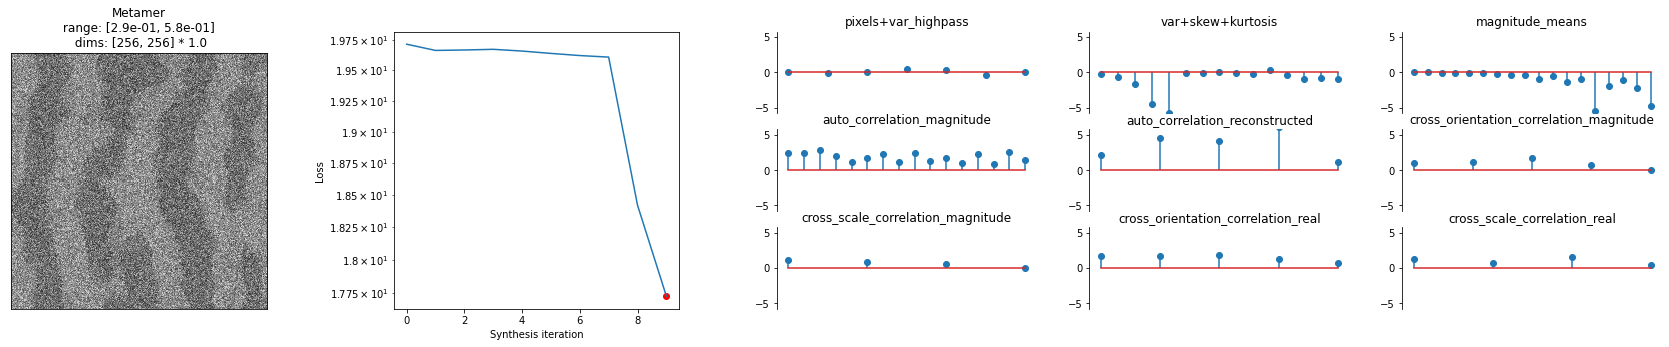

In [13]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'plot_representation_error': 3.1});

In [14]:
# For the remainder of the notebook we will use this helper function to
# run synthesis so that the cells are a bit less busy.

# Be sure to run this cell.

def run_synthesis(img, model, im_init=None):
    r""" Performs synthesis with the full Portilla-Simoncelli model. 

        Parameters
        ----------
        img : Tensor
            A tensor containing an img.
        model :
            A model to constrain synthesis.
        im_init: Tensor
            A tensor to start image synthesis.

        Returns
        -------
        met: Metamer
            Metamer from the full Portilla-Simoncelli Model

        """
    if im_init is None:
        im_init = torch.rand_like(img) * .01 + img.mean()
    met = po.synth.MetamerCTF(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init,
                              coarse_to_fine='together')
    met.synthesize(
        max_iter=long_synth_max_iter, 
        store_progress=True,
        change_scale_criterion=None,
        ctf_iters_to_check=3,
        )
    return met

## 3. The importance of different classes Texture Statistics
The Portilla-Simoncelli consists of a few different classes of statistics:
- Marginal Statistics.  These include pixel statistics (mean, variance, skew, kurtosis, and range of the pixel values), as well as the skewness and kurtosis of the lowpass images computed at each level of the recursive pyramid decomposition.
- Auto-Correlation Statistics.  These include the auto-correlation of the real-valued pyramid bands, as well as the auto-correlation of the magnitude of the pyramid bands, and the mean of the magnitude of the pyramid bands.
- Cross-Correlation Statistics.  These include correlations across scale and across orientation bands of the pyramid (both the for the real values of the pyramid and the magnitude of the pyramid bands).

The original paper uses synthesis to demonstrate the role of these different types of statistics.  They show that the statistics can be used to constrain a synthesis optimization to generate new examples of textures.  They also show that the absence of subsets of statistics results in synthesis failures.  Here we replicate those results.

The first step is to create a version of the Portilla Simoncelli model where certain statistics can be turned off.

In [15]:
#  The following class extends the PortillaSimoncelli model so that you can specify which
#  statistics you would like to remove.  We have created this model so that we can examine
#  the consequences of the absence of specific statistics.  
#
#  Be sure to run this cell.

from collections import OrderedDict
class PortillaSimoncelliRemove(po.simul.PortillaSimoncelli):
    r"""Model for measuring a subset of texture statistics reported by PortillaSimoncelli

    Currently we do not support batch measurement of images.

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model
    remove_keys: list
        The dictionary keys for the statistics we will "remove".  In practice we set them to zero.
        Possible keys: ["pixel_statistics", "magnitude_means", "auto_correlation_magnitude",
        "skew_reconstructed", "kurtosis_reconstructed", "auto_correlation_reconstructed", 
        "std_reconstructed", "cross_orientation_correlation_magnitude", "cross_scale_correlation_magnitude"
        "cross_orientation_correlation_real", "var_highpass_residual"]
    """
    def __init__(
        self,
        im_shape,
        remove_keys,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9, use_true_correlations=True)
        self.remove_keys = remove_keys
        
    def forward(self, image, scales=None):
        r"""Generate Texture Statistics representation of an image with `remove_keys` removed.

        Parameters
        ----------
        image : torch.Tensor
            A tensor containing the image to analyze.
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's ``scales`` attribute.

        Returns
        -------
        representation_vector: torch.Tensor
            A flattened tensor (1d) containing the measured representation statistics.

        """
        # create the representation vector with (with all scales)
        stats_vec = super().forward(image)
        # convert to dict so it's easy to zero out the keys we don't care about
        stats_dict = self.convert_to_dict(stats_vec)
        for kk in self.remove_keys:
            # we zero out the stats (instead of removing them) because removing them 
            # makes it difficult to keep track of which stats belong to which scale 
            # (which is necessary for coarse-to-fine synthesis).
            if isinstance(stats_dict[kk],OrderedDict):
                for (key,val) in stats_dict[kk].items():
                    stats_dict[kk][key] *= 0
            else:
                stats_dict[kk] *= 0
        # then convert back to vector and remove any scales we don't want (for coarse-to-fine)
        stats_vec = self.convert_to_vector(stats_dict)
        if scales is not None:
            stats_vec = self._remove_scales(stats_vec, scales, image.device)
        return stats_vec


### Pixel Statistics + Marginal statistics 
Beginning with some of the pixel and marginal statistics, we'll demonstrate synthesis both with and without combinations of statistics.

The cell below replicates examples of synthesis failures with the following statistics removed:
- the pixel statistics: mean, variance, skew, kurtosis, minimum, maximum and 
- marginal statistics on the lowpass images computed at each level of the recursive pyramid (skew, kurtosis)

These statistics play an important role constraining the histogram of pixel intensities to match across the original and synthesized image. 

(see figure 3 of Portilla & Simoncelli 2000)

In [16]:
# which statistics to remove
remove_statistics = ['pixel_statistics','skew_reconstructed','kurtosis_reconstructed','magnitude_means']

# run on fig3a or fig3b to replicate paper
img = po.tools.load_images(DATA_PATH + 'fig3b.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(img.shape[-2:] ,remove_keys=remove_statistics).to(DEVICE)
metamer_remove = run_synthesis(img, model_remove)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In the following figure, we can see that not only does the metamer created with all statistics look more like the target image than the one creaated without the marginal statistics, but its pixel intensity histogram is much more similar to that of the target image.

Text(0.5, 1.0, 'Without marginal statistics')

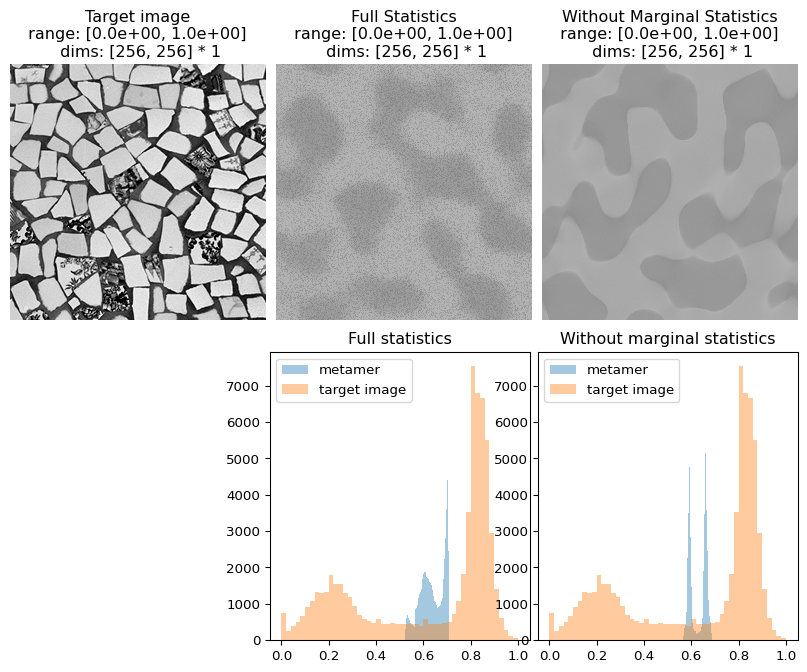

In [17]:
# visualize results
fig = po.imshow([metamer.image, metamer.metamer, metamer_remove.metamer], 
                title=['Target image', 'Full Statistics', 'Without Marginal Statistics'], vrange='auto1');
# add plots showing the different pixel intensity histograms
fig.add_axes([.33, -1, .33, .9])
fig.add_axes([.67, -1, .33, .9])
# this helper function expects a metamer object. see the metamer notebook for details.
po.synth.metamer.plot_pixel_values(metamer, ax=fig.axes[3])
fig.axes[3].set_title('Full statistics')
po.synth.metamer.plot_pixel_values(metamer_remove, ax=fig.axes[4])
fig.axes[4].set_title('Without marginal statistics')

### Coefficient Correlations 
The cell below replicates examples of synthesis failures with the following statistics removed:
- local auto-correlations of the lowpass images computed at each level of the recursive pyramid

These statistics play a role in representing periodic structures and long-range correlations. For example, in the image named fig4b.jpg (the tile pattern) the absence of these statistics causes results in more difficulty synthesizing the long, continuous lines that stretch from one end of the image to the other.

(see figure 4 of Portilla & Simoncelli 2000)

In [18]:
# which statistics to remove
remove_statistics = ['auto_correlation_reconstructed']

# run on fig4a or fig4b to replicate paper
img = po.tools.load_images(DATA_PATH + 'fig4b.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

# synthesis with coefficient correlations  absent
model_remove = PortillaSimoncelliRemove(img.shape[-2:], remove_keys=remove_statistics).to(DEVICE)
metamer_remove = run_synthesis(img, model_remove)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

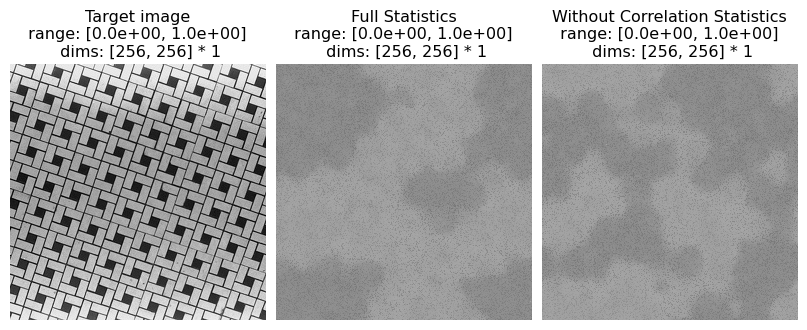

In [19]:
# visualize results
po.imshow([metamer.image, metamer.metamer, metamer_remove.metamer], 
          title=['Target image', 'Full Statistics', 'Without Correlation Statistics'], vrange='auto1');

And we can double check the error plots to see the difference in their representations. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the middle row in the first figure, especially the center plot, `auto_correlation_reconstructed`, since these statistics are unconstrained for the synthesis done by `metamer_remove`. (Note we have to use `model`, not `model_remove` to create these plots, since `model_remove` always zeroes out those statistics.)

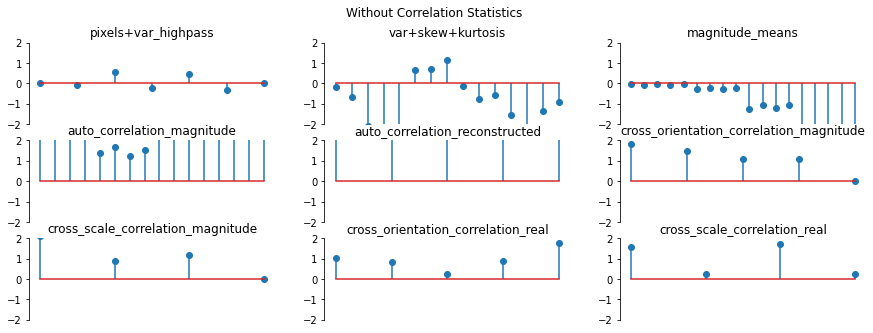

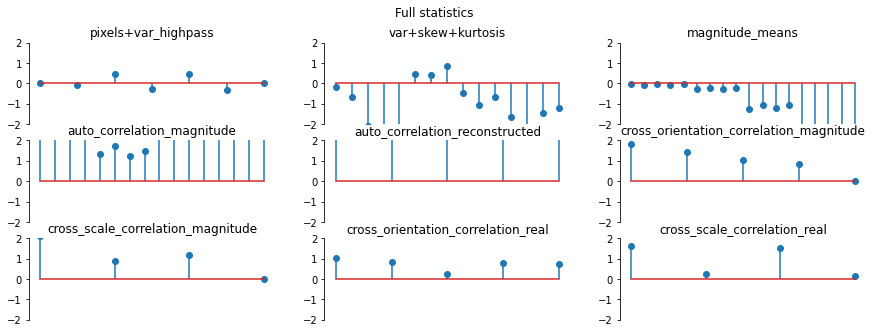

In [20]:
fig, _ = model.plot_representation(model(metamer_remove.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-2, 2))
fig.suptitle('Without Correlation Statistics')

fig, _ = model.plot_representation(model(metamer.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-2, 2))
fig.suptitle('Full statistics');

### Magnitude Correlation 
The cell below replicates examples of synthesis failures with the following statistics removed:
- correlation of the complex magnitude of pairs of coefficients at adjacent positions, orientations and scales.

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. For example, in the image named fig6a.jpg the absence of these statistics results in a completely different organization of the orientation content in the edges.

(see figure 6 of Portilla & Simoncelli 2000)

In [21]:
# which statistics to remove
remove_statistics = ['cross_orientation_correlation_magnitude','cross_scale_correlation_magnitude','auto_correlation_magnitude']

# run on fig6a or fig6b to replicate paper
img = po.tools.load_images(DATA_PATH + 'fig6a.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(img.shape[-2:],remove_keys=remove_statistics).to(DEVICE)
metamer_remove = run_synthesis(img, model_remove)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

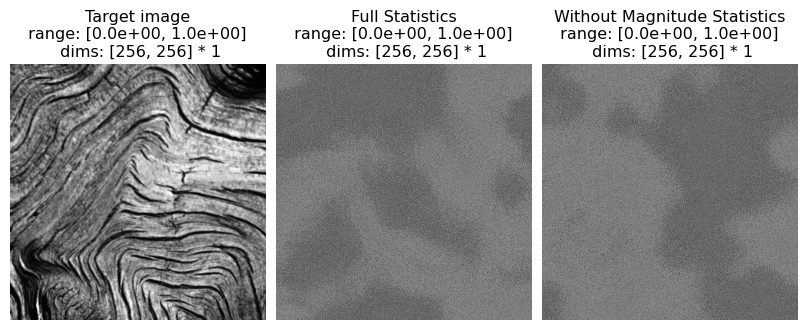

In [22]:
# visualize results
po.imshow([metamer.image, metamer.metamer, metamer_remove.metamer],
          title=['Target image', 'Full Statistics','Without Magnitude Statistics'], vrange='auto1');

And again, let's look at the error plots. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the middle row in the first figure, especially the center plot, `auto_correlation_magnitude` and `cross_orientation_correlation_magnitude`, since these statistics are unconstrained for the synthesis done by `metamer_remove`. (Note we have to use `model`, not `model_remove` to create these plots, since `model_remove` always zeroes out those statistics.)

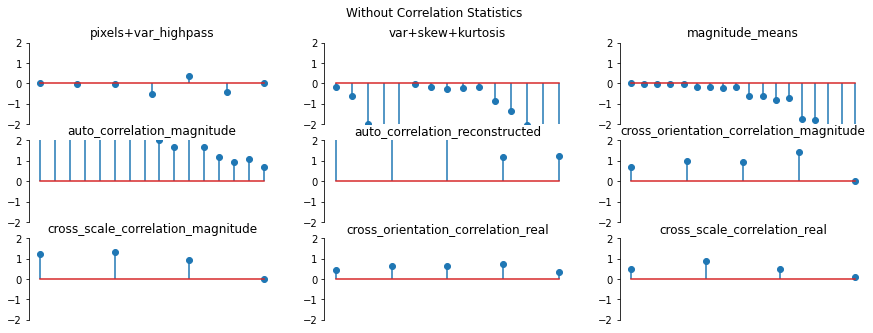

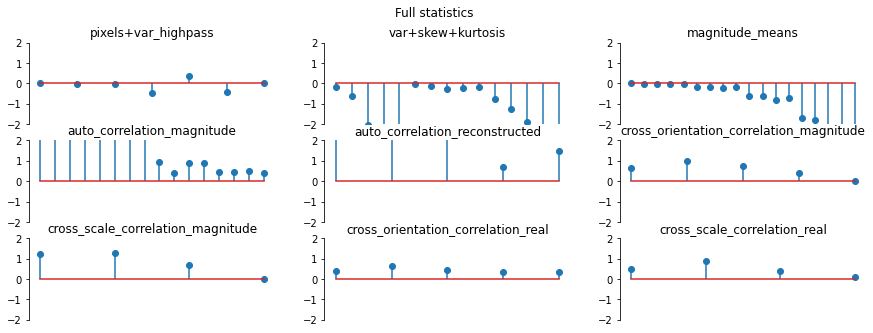

In [23]:
fig, _ = model.plot_representation(model(metamer_remove.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-2, 2))
fig.suptitle('Without Correlation Statistics')

fig, _ = model.plot_representation(model(metamer.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-2, 2))
fig.suptitle('Full statistics');

### Cross-scale Phase Statistics 
The cell below replicates examples of synthesis failures with the following statistics removed :
- relative phase of coefficients of bands at adjacent scales

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. These phase statistics are important in representing textures with strong illumination effects. When they are removed, the synthesized images appear much less three dimensional and lose the detailed structure of shadows.

(see figure 8 of Portilla & Simoncelli 2000)

In [24]:
# which statistics to remove
remove_statistics = ['cross_scale_correlation_real']

# run on fig8a and fig8b to replicate paper
img = po.tools.load_images(DATA_PATH + 'fig8b.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(img.shape[-2:], remove_keys=remove_statistics).to(DEVICE)
metamer_remove = run_synthesis(img, model_remove)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

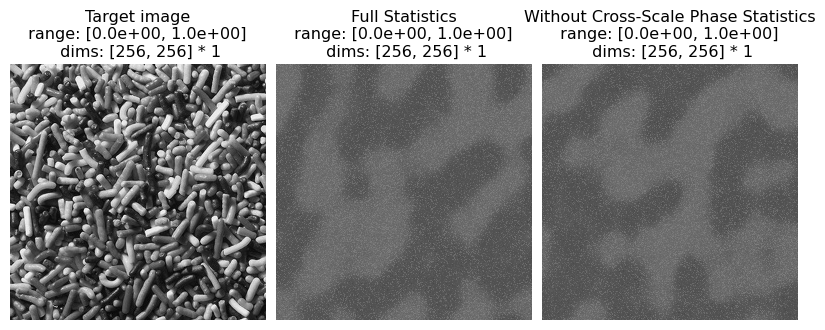

In [25]:
# visualize results
po.imshow([metamer.image, metamer.metamer, metamer_remove.metamer],
          title=['Target image', 'Full Statistics','Without Cross-Scale Phase Statistics'], vrange='auto1');

And again, let's look at the error plots. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the middle row in the first figure, especially the center plot, `cross_scale_correlation_real`, since these statistics are unconstrained for the synthesis done by `metamer_remove`. (Note we have to use `model`, not `model_remove` to create these plots, since `model_remove` always zeroes out those statistics.)

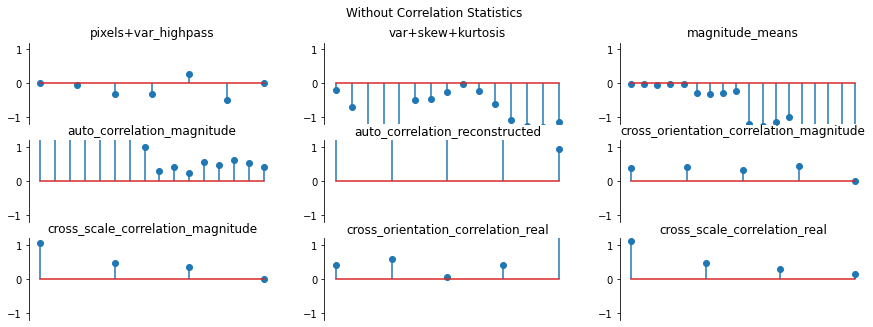

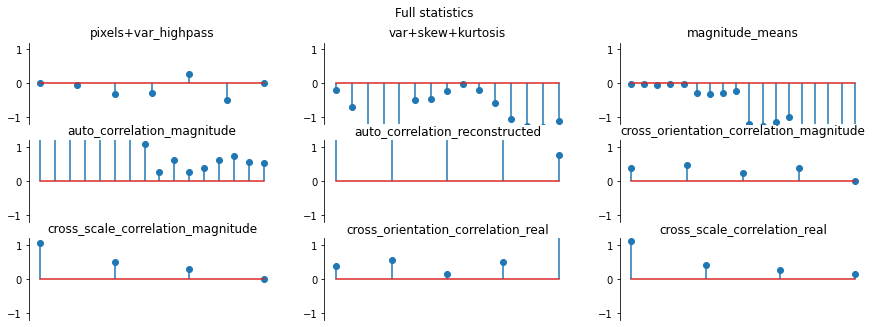

In [26]:
fig, _ = model.plot_representation(model(metamer_remove.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-1.2, 1.2))
fig.suptitle('Without Correlation Statistics')

fig, _ = model.plot_representation(model(metamer.metamer) - model(metamer.image),
                                   figsize=(15, 5), ylim=(-1.2, 1.2))
fig.suptitle('Full statistics');

## 4. Examples from different texture classes

### Artificial Textures 


(see figure 12 of Portilla Simoncelli 2000)

The following cell can be used to reproduce texture synthesis on the artificial texture examples in the original paper, showing that the model can handle these simpler images as well.

Examples

- (12a) solid black squares
- (12b) tilted gray columns
- (12c) curvy lines
- (12d) dashes
- (12e) solid black circles
- (12f) pluses

In [27]:
img = po.tools.load_images(DATA_PATH + 'fig12a.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

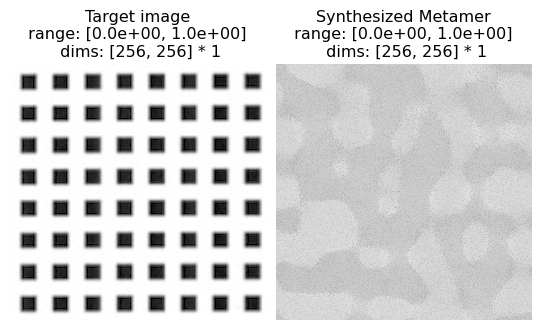

In [28]:
po.imshow([metamer.image, metamer.metamer], 
          title=['Target image', 'Synthesized Metamer'], vrange='auto1');

### Counterexample to the Julesz Conjecture

The Julesz conjecture, originally from [Julesz 1962](https://ieeexplore.ieee.org/abstract/document/1057698), states that "humans cannot distinguish between textures with identical second-order statistics" (second-order statistics include cross- and auto-correlations, see paper for details). Following up on this initial paper, [Julesz et al, 1978](https://link.springer.com/article/10.1007/BF00336998) and then [Yellot, 1993](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-10-5-777) created images that served as counter-examples for this conjecture: pairs of images that had identical second-order statistics (they differed in their third- and higher-order statistics) but were readily distinguishable by humans. In figure 13 of Portilla & Simoncelli, 2000, the authors show that the model is able to synthesize novel images based on these counterexamples that are *also* distinguishbale by humans, so the model does not confuse them either.

(see figure 13 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 13 shows two pairs of counterexamples that have been used to refute the Julesz conjecture. \[13a and 13b were \] originally created by Julesz et al. (1978): they have identical third-order pixel statistics, but are easily discriminated by human observers. Our model succeeds, in that it can reproduce the visual appearance of either of these textures. In particular, we have seen that the strongest statistical difference arises in the magnitude correlation statistcs. The rightmost pair were constructed by Yellott (1993), to have identical sample autocorrelation. Again, our model does not confuse these, and can reproduce the visual appearance of either one."_

In [29]:
# Run on fig13a, fig13b, fig13c, fig13d to replicate examples in paper
img = po.tools.load_images(DATA_PATH + 'fig13a.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer_left = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
# Run on fig13a, fig13b, fig13c, fig13d to replicate examples in paper
img = po.tools.load_images(DATA_PATH + 'fig13b.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer_right = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

And note that the two synthesized images (right column) or as distinguishable from each other as the two hand-crafted counterexamples (left column):

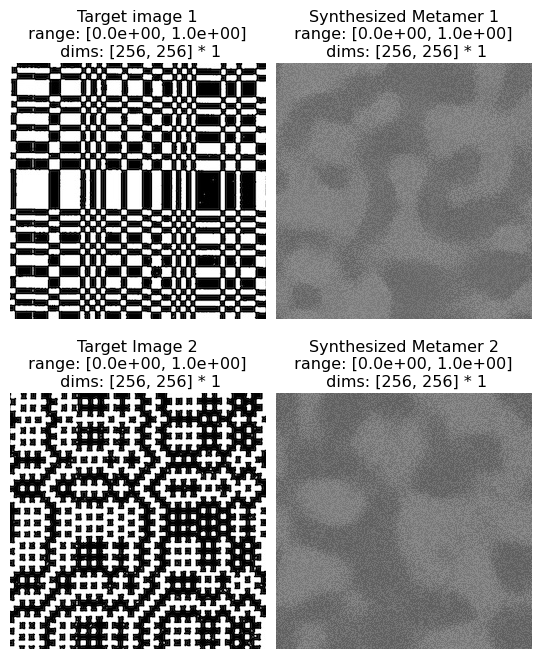

In [31]:
po.imshow([metamer_left.image, metamer_left.metamer, 
           metamer_right.image, metamer_right.metamer],
          title=['Target image 1', 'Synthesized Metamer 1', 'Target Image 2', 'Synthesized Metamer 2'],
          vrange='auto1', col_wrap=2);

### Pseudo-periodic Textures 

(see figure 14 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 14 shows synthesis results photographic textures that are pseudo-periodic, such as a brick wall and various types of woven fabric"_

In [32]:
# Run on fig14a, fig14b, fig14c, fig14d, fig14e, fig14f to replicate examples in paper
img = po.tools.load_images(DATA_PATH + 'fig14a.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

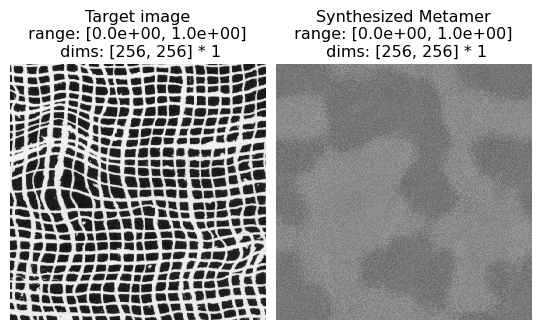

In [33]:
po.imshow([metamer.image, metamer.metamer],
          title=['Target image', 'Synthesized Metamer'], vrange='auto1');

### Aperiodic Textures 

(see figure 15 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 15 shows synthesis results for a set of photographic textures that are aperiodic, such as the animal fur or wood grain"_

In [34]:
# Run on fig15a, fig15b, fig15c, fig15d to replicate examples in paper
img = po.tools.load_images(DATA_PATH + 'fig15a.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

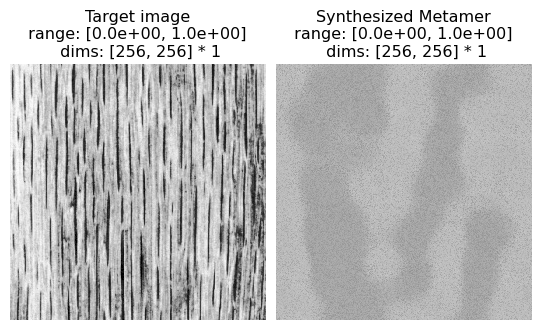

In [35]:
po.imshow([metamer.image, metamer.metamer],
          title=['Target image', 'Synthesized Metamer'], vrange='auto1');

### Complex Structured Photographic Textures 

(see figure 16 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 16 shows several examples of textures with complex structures. Although the synthesis quality is not as good as in previous examples, we find the ability of our model to capture salient visual features of these textures quite remarkable. Especially notable are those examples in all three figures for which shading produces a strong impression of three-dimensionality."_

In [36]:
# Run on fig16a, fig16b, fig16c, fig16d to replicate examples in paper
img = po.tools.load_images(DATA_PATH + 'fig16e.jpg').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

  0%|          | 0/10 [00:00<?, ?it/s]

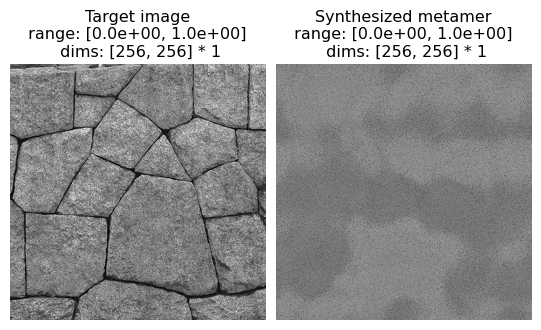

In [37]:
po.imshow([metamer.image, metamer.metamer],
          title=['Target image', 'Synthesized metamer'], vrange='auto1');

## 5. Extrapolation

(see figure 19 of Portilla & Simoncelli 2000)

Here we explore using the texture synthesis model for extrapolating beyond its spatial boundaries.

Excerpt from paper: _"...\[C\]onsider the problem of extending a texture image beyond its spatial boundaries (spatial extrapolation). We want to synthesize an image in which the central pixels contain a copy of the original image, and the surrounding pixels are synthesized based on the statistical measurements of the original image. The set of all images with the same central subset of pixels is convex, and the projection onto such a convex set is easily inserted into the iterative loop of the synthesis algorithm. Specifically, we need only re-set the central pixels to the desired values on each iteration of the synthesis loop. In practice, this substitution is done by multiplying the desired pixels by a smooth mask (a raised cosine) and adding this to the current synthesized image multiplied by the complement of this mask. The smooth mask prevents artifacts at the boundary between original and synthesized pixels, whereas convergence to the desired pixels within the mask support region is achieved almost perfectly. This technique is applicable to the restoration of pictures which have been destroyed in some subregion (“filling holes”) (e.g., Hirani and Totsuka, 1996), although the estimation of parameters from the defective image is not straightforward. Figure 19 shows a set of examples that have been spatially extrapolated using this method. Observe that the border between real and synthetic data is barely noticeable. An additional potential benefit is that the synthetic images are seamlessly periodic (due to circular boundary-handling within our algorithm), and thus may be used to tile a larger
image."_

In the following, we mask out the boundaries of an image and use the texture model to extend it.

In [38]:
# The following class inherits from the PortillaSimoncelli model for 
# the purpose of extrapolating (filling in) a chunk of an imaged defined
# by a mask.

class PortillaSimoncelliMask(po.simul.PortillaSimoncelli):
    r"""Extend the PortillaSimoncelli model to operate on masked images.

    Additional Parameters
    ----------
    mask: Tensor
        boolean mask with True in the part of the image that will be filled in during synthesis
    target: Tensor
        image target for synthesis

    """
    def __init__(
        self,
        im_shape,
        n_scales=4,
        n_orientations=4,
        spatial_corr_width=9,
        use_true_correlations=True,
        mask=None,
        target=None
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9, use_true_correlations=True)
        self.mask = mask;
        self.target = target;
        
    def forward(self, image, scales=None):
        r"""Generate Texture Statistics representation of an image using the target for the masked portion

        Parameters
        ----------
        images : torch.Tensor
            A 4d tensor containing two images to analyze, with shape (2,
            channel, height, width).
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's ``scales`` attribute.

        Returns
        -------
        representation_vector: torch.Tensor
            A flattened tensor (1d) containing the measured representation statistics.

        """
        if self.mask is not None and self.target is not None:
            image = self.texture_masked_image(image)
            
        return super().forward(image,scales=scales)
    
    def texture_masked_image(self,image):
        r""" Fill in part of the image (designated by the mask) with the saved target image
        
        Parameters
        ------------
        image : torch.Tensor
            A tensor containing a single image
            
        Returns
        -------
        texture_masked_image: torch.Tensor
            An image that is a combination of the input image and the saved target.  
            Combination is specified by self.mask
        
        """
        return self.target*self.mask + image*(~self.mask)

In [39]:
img_file = DATA_PATH + 'fig14b.jpg'
img = po.tools.load_images(img_file).to(DEVICE)
im_init = (torch.rand_like(img)-.5) * .1 + img.mean();

mask = torch.zeros(1,1,256,256).bool().to(DEVICE)
mask[:,:,64:192,64:192] = True

model = PortillaSimoncelliMask(img.shape[-2:], target=img, mask=mask).to(DEVICE)
met = po.synth.MetamerCTF(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init,
                          coarse_to_fine='together')

optimizer = torch.optim.Adam([met.metamer],lr=.02, amsgrad=True)

met.synthesize(
    optimizer=optimizer,
    max_iter=short_synth_max_iter, 
    store_progress=True,
    change_scale_criterion=None,
    ctf_iters_to_check=3
    )

  0%|          | 0/10 [00:00<?, ?it/s]

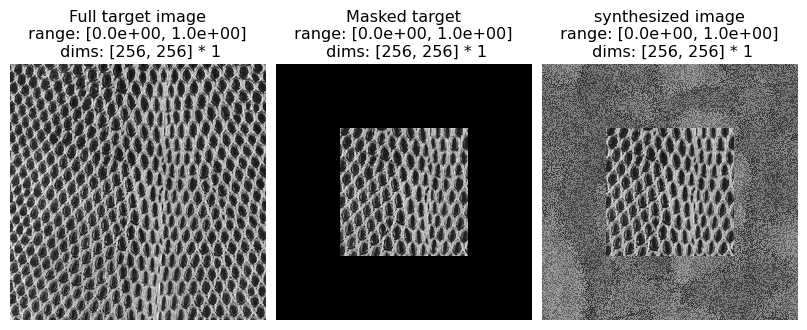

In [40]:
po.imshow([met.image, mask*met.image, model.texture_masked_image(met.metamer)], vrange='auto1',
          title=['Full target image', 'Masked target' ,'synthesized image']);

### 4.2 Mixtures

Here we explore creating a texture that is "in between" two textures by averaging their texture statistics and synthesizing an image that matches those average statistics.  \[Note: This implementation seems to perform differently and perhaps worse than the original matlab implementation.\]

Excerpt from paper: _"... \[C\]onsider the problem of creating a texture that lies visually “in between” two other textures. The parameter space consisting of spatial averages of local functions has a type of convexity property in the limit as the image lattice grows in size.3 Figure 20 shows three images synthesized from parameters that are an average of the parameters for two example textures. In all three cases, the algorithm converges to an interesting-looking image that appears to be a patchwise mixtures of the two initial textures, rather than a new homogeneous texture that lies perceptually between them. Thus, in our model, the subset of parameters corresponding to textures (homogeneous RFs) is not convex!"_

In [41]:
# The following classes are designed to extend the PortillaSimoncelli model 
# and the Metamer synthesis method for the purpose of mixing two target textures.

class PortillaSimoncelliMixture(po.simul.PortillaSimoncelli):
    r"""Extend the PortillaSimoncelli model to mix two different images

        Parameters
        ----------
        im_shape: int
            the size of the images being processed by the model

    """
    def __init__(
        self,
        im_shape,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9, 
                         use_true_correlations=True)
        
        
    def forward(self, images, scales=None):
        r"""Average Texture Statistics representations of two image

        Parameters
        ----------
        images : torch.Tensor
            A 4d tensor containing one or two images to analyze, with shape (i,
            channel, height, width), i in {1,2}.
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's ``scales`` attribute.

        Returns
        -------
        representation_vector: torch.Tensor
            A flattened tensor (1d) containing the measured representation statistics.

        """
        if images.shape[0] == 2:
            # need the images to be 4d, so we use the "1 element slice"
            stats0 = super().forward(images[:1], scales=scales)
            stats1 = super().forward(images[1:2], scales=scales)
            return (stats0+stats1)/2
        else:
            return super().forward(images, scales=scales)
            
class MetamerMixture(po.synth.MetamerCTF):
    r""" Extending metamer synthesis based on image-computable 
    differentiable models, for mixing two images.
    """
    def _initialize(self, initial_image):
        """Initialize the metamer.

        Set the ``self.metamer`` attribute to be a parameter with
        the user-supplied data, making sure it's the right shape.

        Parameters
        ----------
        initial_image :
            The tensor we use to initialize the metamer. If None (the
            default), we initialize with uniformly-distributed random
            noise lying between 0 and 1.

        """
        if initial_image.ndimension() < 4:
            raise Exception("initial_image must be torch.Size([n_batch"
                            ", n_channels, im_height, im_width]) but got "
                            f"{initial_image.size()}")
        # the difference between this and the regular version of Metamer is that
        # the regular version requires synthesized_signal and target_signal to have
        # the same shape, and here target_signal is (2, 1, 256, 256), not (1, 1, 256, 256)
        metamer = initial_image.clone().detach()
        metamer = metamer.to(dtype=self.image.dtype,
                             device=self.image.device)
        metamer.requires_grad_()
        self._metamer = metamer

In [42]:
# Figure 20. Examples of “mixture” textures.
# To replicate paper use the following combinations: 
# (Fig. 15a, Fig. 15b); (Fig. 14b, Fig. 4a); (Fig. 15e, Fig. 14e).

img_files = [DATA_PATH + 'fig15e.jpg', DATA_PATH + 'fig14e.jpg']
imgs = po.tools.load_images(img_files).to(DEVICE)
im_init = torch.rand_like(imgs[0,:,:,:].unsqueeze(0)) * .01 + imgs.mean()
n=imgs.shape[-1]

model = PortillaSimoncelliMixture([n,n]).to(DEVICE)
met = MetamerMixture(imgs, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init,
                     coarse_to_fine='together')

optimizer = torch.optim.Adam([met.metamer],lr=.02, amsgrad=True)

met.synthesize(
    optimizer=optimizer,
    max_iter=longest_synth_max_iter, 
    store_progress=True,
    change_scale_criterion=None,
    ctf_iters_to_check=3
    )

  0%|          | 0/10 [00:00<?, ?it/s]

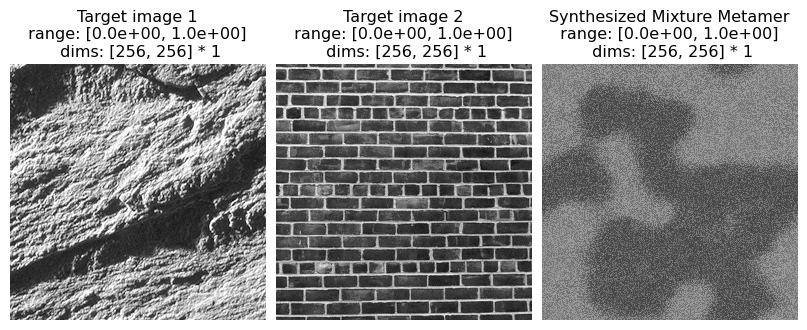

In [43]:
po.imshow([met.image, met.metamer], vrange='auto1',title=['Target image 1', 'Target image 2', 'Synthesized Mixture Metamer']);

## 6. Model Limitations

Not all texture model metamers look perceptually similar to humans. The paper's figures 17 and 18 present two classes of failures: "inhomogeneous texture images not usually considered to be 'texture'" (such as human faces, fig. 17) and some simple artificial textures (fig. 18), many of which are simple geometric line drawings.

Note that for these examples, we were unable to locate the original images, so we present examples that serve the same purpose. 

In [44]:
img = po.tools.load_images('../data/256/einstein.pgm').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

  0%|          | 0/10 [00:00<?, ?it/s]

Here we can see that the texture model fails to capture anything that makes this image look "portrait-like": there is no recognizable face or clothes in the synthesized metamer. As a portrait is generally not considered a texture, this is not a model *failure* per se, but does demonstrate the limits of this model.

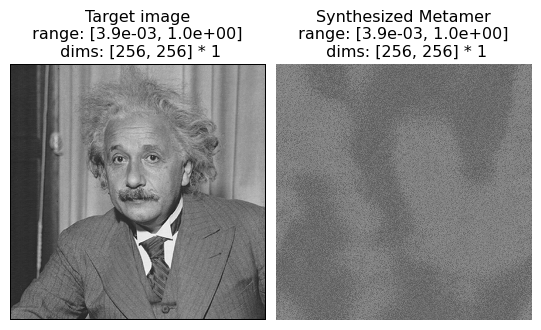

In [45]:
po.imshow([metamer.image, metamer.metamer],
          title=['Target image', 'Synthesized Metamer'], vrange='auto1');

In this example, we see the model metamer fails to reproduce the randomly distributed oriented black lines on a white background: in particular, several lines are curved and several appear discontinuous. From the paper: "Althought a texture of single-orientation bars is reproduced fairly well (see Fig. 12), the mixture of bar orientations in this example leads ot the synthesis of curved line segments. In general, the model is unable to distinguish straight from curved contours, except when the contours are all of the same orientation."

In [46]:
img = po.tools.load_images(DATA_PATH + 'fig18a.png').to(DEVICE)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
metamer = run_synthesis(img, model)

  0%|          | 0/10 [00:00<?, ?it/s]

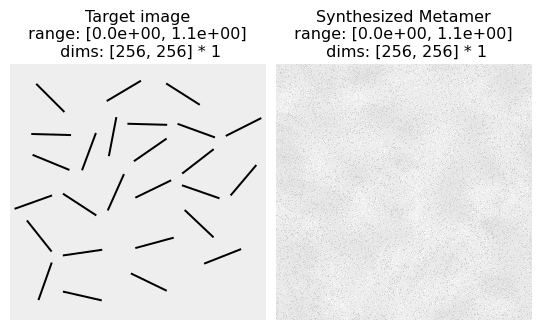

In [47]:
po.imshow([metamer.image, metamer.metamer],
          title=['Target image', 'Synthesized Metamer'], vrange='auto1');

## 7. Notable differences between Matlab and Python Implementations:

1. Optimization.  The matlab implementation of texture synthesis is designed specifically for the texture model.  Gradient descent is performed on subsets of the texture statistics in a particular sequence (coarse-to-fine, etc.). The python implementation relies on the auto-differentiation and optimization tools available in pytorch.  We only define the forward model and then allow pytorch to handle the optimization.

    Why does this matter? We have qualitatively reproduced the results but cannot guarantee exact reproducibility. This is also true in general for the plenoptic package: [https://plenoptic.readthedocs.io/en/latest/reproducibility.html](https://plenoptic.readthedocs.io/en/latest/reproducibility.html) This means that, in general, metamers synthesized by the two versions will differ.
 
 
2. In the [Matlab implementation of Portilla Simoncelli statistics](https://github.com/LabForComputationalVision/textureSynth) and when the python is set with `use_true_correlations=False`, the auto-correlation, cross-scale and cross-orientation statistics are based on co-variance matrices.  For the python optimization, this makes it more difficult for the optimization to converge.  We have adjusted the default behavior of the python implementation to use cross-correlation matrices instead of covariance matrices for these auto-correlation, cross-scale, and cross-orientation statistics.

    In the case where `use_true_correlation=False`, the matlab and python statistics calculations are identical up to floating point error.  We test for this directly in `tests/test_models.py` in the function `test_ps_torch_v_matlab`
    
    Thus, if you are trying to synthesize anything with this model, it is recommended to use the (default) `use_true_correlations=True`. It is only recommended to set it to `False` if you are trying to exactly match the original implementation's output (e.g., for reproducing something).
    
    The following cells demonstrate the effect of this `use_true_correlations` argument. 

In [48]:
img = po.tools.load_images(DATA_PATH + 'fig6a.jpg').to(DEVICE)

# Example of synthesis where use_true_correlations=True
model = po.simul.PortillaSimoncelli(img.shape[-2:],use_true_correlations=True).to(DEVICE)
metamer_true = run_synthesis(img,model)

# Example of synthesis where use_true_correlations=False
img = po.tools.load_images(DATA_PATH + 'fig6a.jpg').to(DEVICE)
model = po.simul.PortillaSimoncelli(img.shape[-2:],use_true_correlations=False).to(DEVICE)
metamer_false = run_synthesis(img,model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

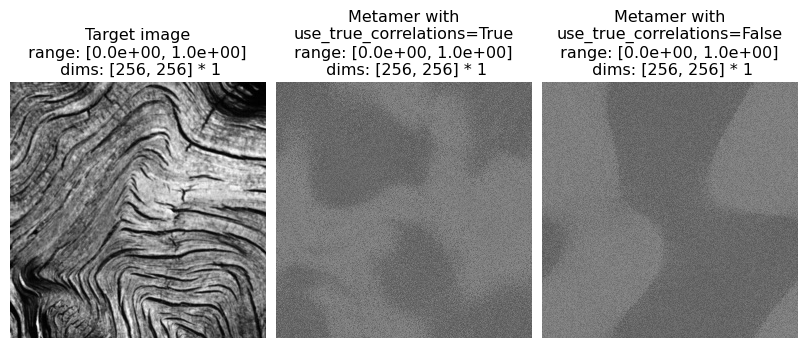

In [49]:
po.imshow([metamer_true.image, metamer_true.metamer, metamer_false.metamer], 
          title=['Target image', 'Metamer with\nuse_true_correlations=True', 'Metamer with\nuse_true_correlations=False'], vrange='auto1');